In [19]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
import random

In [20]:
img_df = pd.read_csv("./train.csv")
img_df.head()

,ID,img_path,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,TRAIN_00000,./train/TRAIN_00000.jpg,8,1,16,12,5,10,14,2,13,4,7,3,6,9,11,15
1,TRAIN_00001,./train/TRAIN_00001.jpg,3,7,2,13,1,5,10,4,11,14,9,15,16,12,8,6
2,TRAIN_00002,./train/TRAIN_00002.jpg,9,12,11,14,6,16,10,13,15,8,3,1,4,5,2,7
3,TRAIN_00003,./train/TRAIN_00003.jpg,14,1,6,15,9,4,8,5,16,10,13,7,2,3,11,12
4,TRAIN_00004,./train/TRAIN_00004.jpg,3,15,12,4,16,13,11,10,9,6,14,5,1,8,2,7


In [21]:
img_path = img_df["img_path"][0]

image = Image.open(img_path)

In [22]:
# 4*4로 자르기 위해 비율을 구하고 저장
img_w = image.width
img_h = image.height

w_rate = img_w/4
h_rate = img_h/4

# 자를 때 시작점을 지정해 줘야 하기에 0부터 시작
w_size_arr = [0]
h_size_arr = [0]

for i in range(1,5):
    w_size = i * w_rate
    h_size = i * h_rate

    w_size_arr.append(w_size)
    h_size_arr.append(h_size)

In [23]:
# 쪼갠 후 배열로 만들어 저장할때
count = 0
images = []
for i in range(len(w_size_arr)-1):
    for j in range(len(h_size_arr)-1):
        # 이미지를 4*4로 자르고 저장
        resize_img = image.crop((w_size_arr[j], h_size_arr[i], w_size_arr[j+1], h_size_arr[i+1]))
        # 이제 이미지를 배열로 만들고 배열을 저장한다.
        images.append(np.array(resize_img))

In [24]:
# 이미지 선따기
merged = Image.new('RGB', (img_w, img_h)) # "RGB" 대신 "L"이 들어가면 흑백이 된다.

edge = []
cnt = 0
for i in range(len(w_size_arr)-1):
    for j in range(len(h_size_arr)-1):
        edge.append(cv2.Canny(images[cnt],300,300))
        im = Image.fromarray(edge[cnt])
        cnt += 1
        merged.paste(im, (int(w_rate) * j, int(h_rate) * i))

# 4. 병합한 이미지 저장하기
# merged.save(f'./img2/{img_df["ID"][n]}.jpg')

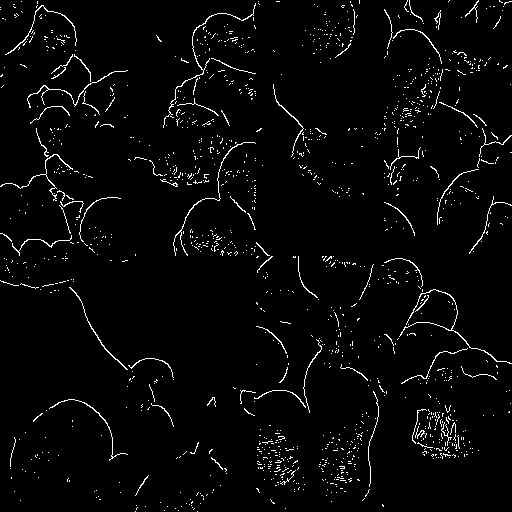

In [25]:
merged

In [26]:
# 조각의 인접한 변의 일치에 따라 점수를 매기고 6점이 시작 조각
count = 0
for i in range(len(edge)):
    for k in range(len(edge)):
        main = edge[i]
        compare = edge[k]
        max_size = main.shape[0]-1
        
        up_score = 0
        down_score = 0
        r_score = 0
        l_score = 0
            
        compare_up = []
        compare_down = []
        compare_r = []
        compare_l = []

        main_up = []
        main_down = []
        main_r = []
        main_l = []
            
        for j in range(main.shape[0]):
            count = i+1
            # 선으로 변환이 완벽하지 않기에 정확하게 찾질 못 한다.
                        
            main_up.append(main[j][0])
            main_r.append(main[j][max_size])
            main_down.append(main[max_size][j])
            main_l.append(main[0][j])
            
            compare_up.append(compare[j][0])
            compare_r.append(compare[j][max_size])
            compare_down.append(compare[max_size][j])
            compare_l.append(compare[0][j])
        
        # 메인의 위, 비교의 아래
        if np.all(main_up == compare_down):
            up_score = 1
        # 메인의 오른쪽, 비교의 왼쪽
        if np.all(main_r == compare_l):
            r_score = 2
        # 메인의 아래, 비교의 위
        if np.all(main_down == compare_up):
            down_score = 4
        # 메인의 왼쪽, 비교의 오른쪽
        if np.all(main_l == compare_r):
            l_score = 8

        score = (up_score + down_score + r_score + l_score)

        # print(score)
        # print("-"*80)

        if score == 6:
            print(count)
            print(score)
            print("-"*80)

16
6
--------------------------------------------------------------------------------
16
6
--------------------------------------------------------------------------------


In [27]:
# 각 이미지의 꼭짓점이 일치하는지 확인하는 방식
for i in range(len(images)):
    for k in range(len(images)):
        main = images[i]
        compare = images[k]
        max_size = main.shape[0]-1
        
        up_score = 0
        down_score = 0
        r_score = 0
        l_score = 0
        score = (up_score + down_score + r_score + l_score)
        
        # (좌상, 우상), (좌하, 우하) = 위쪽변, 아랫쪽변
        if (main[0][0] == compare[0][max_size]) & (main[max_size][0] == compare[max_size][max_size]):
            up_score = 1            
        # (우상, 우하), (좌상, 좌하) = 오른쪽변, 왼쪽변
        if (main[max_size][0] == compare[0][0]) & (main[max_size][max_size] == compare[0][max_size]):
            r_score = 2
        # (좌하, 우하), (좌상, 우상) = 아랫쪽변, 윗쪽변
        if (main[0][max_size] == compare[0][0]) & (main[max_size][max_size] == compare[max_size][0]):
            down_score = 4
        # (좌상, 좌하), (우상, 우하) = 왼쪽변, 오른쪽변
        if (main[max_size][max_size] == compare[max_size][0]) & (main[0][max_size] == compare[max_size][max_size]):
            l_score = 8
        
        print(up_score)
        print("-"*80)
        
        if score == 6:
            print(count)
            print(score)
            print("-"*80)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()